Cloning coatnet.py and importing modules

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn


from einops import rearrange
from einops.layers.torch import Rearrange


def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return x + self.conv(x)


class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x


class CoAtNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=1000, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 32, iw // 32))

        self.pool = nn.AvgPool2d(ih // 32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)


def coatnet_0():
    num_blocks = [2, 2, 3, 5, 2]            # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_1():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_2():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [128, 128, 256, 512, 1026]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_3():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_4():
    num_blocks = [2, 2, 12, 28, 2]          # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



Random 3x224x224 images

In [ ]:
images = torch.randn(5,3,32,32)

In [ ]:
s0 = conv_3x3_bn(3,64,(16,16),downsample = True) #imsize is the output size
s0_output = s0(images)
print(s0_output.shape)

torch.Size([5, 64, 16, 16])


In [ ]:
s1 = MBConv(64,96,(8,8),downsample = True,expansion=4)
s1_output = s1(s0_output)
print(s1_output.shape)

torch.Size([5, 96, 8, 8])


In [ ]:
s2 = MBConv(96,192,(4,4),downsample = True, expansion = 4)
s2_output = s2(s1_output)
print(s2_output.shape)

torch.Size([5, 192, 4, 4])


In [ ]:
s3 = Transformer(192,384,(2,2),downsample = True)
s3_output = s3(s2_output)
print(s3_output.shape)

torch.Size([5, 384, 2, 2])


In [ ]:
s4 = Transformer(384,768,(1,1),downsample = True)
s4_output = s4(s3_output)
print(s4_output.shape)

torch.Size([5, 768, 1, 1])


In [ ]:
upsamplerrr = nn.ConvTranspose2d(3072,200,2,2)
test = upsamplerrr(s4_output)
print(test.shape)

torch.Size([5, 200, 2, 2])


In [ ]:
s4_output[0,0,:,:]

tensor([[-0.1653]], grad_fn=<SliceBackward0>)

Symmetrical Coatnet

In [ ]:
#----------------Same as CoAtNet--------------------------
import torch
import torch.nn as nn


from einops import rearrange
from einops.layers.torch import Rearrange

class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y
class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

# -----------------Symmetric CoAtNet Modules--------------
class Bicubic_upsampler(nn.Module):
    def __init__(self,scale_factor,mode):
      super(Bicubic_upsampler,self).__init__()
      self.upsampler = nn.functional.interpolate
      self.scale_factor = scale_factor
      self.mode = mode
    def forward(self,x):
      x = self.upsampler(x,scale_factor = self.scale_factor, mode = self.mode)
      return x


class InverseTransformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, upsample=False, dropout=0.):
        super().__init__()
        

        self.ih, self.iw = image_size
        self.upsample = upsample
        
        
        if self.upsample: #We can change the upsampling method at some point.
          #Maybe using bicubic interpolation might be better
          
          # self.upsampler = nn.PixelShuffle(2) # 2 is the upsample factor can be a hyperparameter
          # inp = int(inp/4) # after upsampling 
          self.upsampler = nn.ConvTranspose2d(inp,inp,kernel_size=2,stride=2,bias=False) 

          # Not needed since pixelshuffle reduces channels while upsampling, Needed when using bicubic interpolation
          # self.upsampler = Bicubic_upsampler(scale_factor = 2, mode = "bicubic")
          self.proj = nn.ConvTranspose2d(inp, oup, 1, 1, 0, bias=False) 

        hidden_dim = int(inp * 4)
        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.upsample:
            x = self.proj(self.upsampler(x)) + self.attn(self.upsampler(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x

class InverseMBConv(nn.Module):
    def __init__(self, inp, oup, image_size, upsample=False, expansion=4):
        super().__init__()
        self.upsample = upsample
        stride = 1 if self.upsample == False else 2
        output_padding = 0 if self.upsample == False else 1

        if self.upsample:
            # self.upsampler = nn.PixelShuffle(2)
            # self.upsampler = Bicubic_upsampler(scale_factor = 2, mode = "bicubic")
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)
            self.upsampler = nn.ConvTranspose2d(inp,inp,kernel_size=2,stride=2,bias=False)
        
        hidden_dim = int(inp * expansion)
      
        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(inp, hidden_dim, 3, stride,
                          1, groups=inp, bias=False,output_padding = output_padding),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # up-sample in the first conv
                nn.ConvTranspose2d(inp, hidden_dim, 1, stride, 0, bias=False,output_padding = output_padding),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.upsample:
            return self.proj(self.upsampler(x)) + self.conv(x)
        else:
            return x + self.conv(x)

def Inverse_conv_3x3_bn(inp, oup, image_size, upsample=False):
    stride = 1 if upsample == False else 2
    output_padding = 0 if upsample == False else 1
    return nn.Sequential(
        nn.ConvTranspose2d(inp, oup, 3, stride, 1, bias=False,output_padding = output_padding),
        nn.BatchNorm2d(oup),
        nn.Tanh()
    )

Recreating the Image

In [ ]:
g4 = InverseTransformer(768,384,(2,2),upsample = True)
g4_output = g4(s4_output)
print(g4_output.shape)

torch.Size([5, 384, 2, 2])


In [ ]:
g3 = InverseTransformer(384,192,(4,4),upsample = True)
g3_output = g3(g4_output)
print(g3_output.shape)

torch.Size([5, 192, 4, 4])


In [ ]:
g2 = InverseMBConv(192,96,(8,8),upsample = True)
g2_output = g2(g3_output)
print(g2_output.shape)

torch.Size([5, 96, 8, 8])


In [ ]:
g1 = InverseMBConv(96,64,(16,16),upsample = True)
g1_output = g1(g2_output)
print(g1_output.shape)

torch.Size([5, 64, 16, 16])


In [ ]:
g0 = Inverse_conv_3x3_bn(64,3,(32,32),upsample = True)
g0_output = g0(g1_output)
print(g0_output.shape)

torch.Size([5, 3, 32, 32])


In [ ]:
lolconv = nn.ConvTranspose2d(192,768,1,2,0,bias=False, output_padding = 1)
test = lolconv(g3_output)
print(test.shape)
testconv = nn.ConvTranspose2d(768,768,3,1,1,groups = 768,bias = False)
test = testconv(test)
print(test.shape)
se = SE(192,768)
test = se(test)
print(test.shape)
pwconv = nn.ConvTranspose2d(768,48,1,1,0,bias = False)
test = pwconv(test)
print(test.shape)

torch.Size([1, 768, 56, 56])
torch.Size([1, 768, 56, 56])
torch.Size([1, 768, 56, 56])
torch.Size([1, 48, 56, 56])


Merged Auto Encoder

In [ ]:
# class MLP(nn.Module):
#   def __init__(self,inp,oup,dropout = 0.):
#     super().__init__()
#     hidden = int(inp/2)
#     self.fc1 = nn.Linear(inp,hidden)
#     self.act = nn.GELU()
#     self.fc2 = nn.Linear(hidden,oup)
#     self.drop = nn.Dropout(dropout)
#     self.norm_layer1 = nn.LayerNorm(hidden)
#     self.norm_layer2 = nn.LayerNorm(oup)
#   def forward(self,x):
#     x = rearrange(x,'b c h w -> b h w c')
#     x = self.fc1(x)
#     # x = self.norm_layer1(x)
#     x = self.act(x)
#     x = self.drop(x)
#     x = self.fc2(x)
#     # x = self.norm_layer2(x)
#     x = self.drop(x)
#     x = rearrange(x,'b h w c -> b c h w')
#     return x

# class Inverse_MLP(nn.Module):
#   def __init__(self,inp,oup,dropout = 0.):
#     super().__init__()
#     hidden = int(inp*2)
#     self.fc1 = nn.Linear(inp,hidden)
#     self.act = nn.GELU()
#     self.fc2 = nn.Linear(hidden,oup)
#     self.drop = nn.Dropout(dropout)
#     self.norm_layer1 = nn.LayerNorm(hidden)
#     self.norm_layer2 = nn.LayerNorm(oup)
#   def forward(self,x):
#     x = rearrange(x,'b c h w -> b h w c')
#     x = self.fc1(x)
#     # x = self.norm_layer1(x)
#     x = self.act(x)
#     x = self.drop(x)
#     x = self.fc2(x)
#     # x = self.norm_layer2(x)
#     x = self.drop(x)
#     x = rearrange(x,'b h w c -> b c h w')
#     return x

class MergedAutoEncoder(nn.Module):
  def __init__(self):
    super(MergedAutoEncoder,self).__init__()
    ######### encoder layers #########
    #self.a0 =  conv_3x3_bn(3,12,(16,16),downsample = True)
    self.a0 = self._make_layer_analysis(conv_3x3_bn,3,128,1,(16,16))
    # self.gdn12 = GDN(12)

    #self.a1 = MBConv(12,48,(8,8),downsample = True)
    self.a1 = self._make_layer_analysis(MBConv,128,128,2,(8,8))
    # self.gdn48 = GDN(48)

    #self.a2 = MBConv(48,192,(4,4),downsample = True)
    self.a2 = self._make_layer_analysis(MBConv,128,256,6,(4,4))
    # self.gdn192 = GDN(192)

    #self.a3 = Transformer(192,768,(2,2),downsample=True)
    self.a3 = self._make_layer_analysis(Transformer,256,512,14,(2,2))
    # self.gdn768 = GDN(768)

    #self.a4 = Transformer(768,3072,(1,1),downsample = True)
    self.a4 = self._make_layer_analysis(Transformer,512,1024,2,(1,1))
    # self.gdn3072 = GDN(3072)

    # self.compress = MLP(3072,192)

    ######### decoder layers #########

    # self. decompress = Inverse_MLP(192,3072)

    #self.s4 = InverseTransformer(3072,768,(2,2),upsample = True)
    self.s4 = self._make_layer_synthesis(InverseTransformer,1024,512,2,(2,2))
    # self.igdn768 = GDN(768,inverse=True)

    #self.s3 = InverseTransformer(768,192,(4,4),upsample = True)
    self.s3 = self._make_layer_synthesis(InverseTransformer,512,256,14,(4,4))
    # self.igdn192 = GDN(192,inverse=True)

    # self.s2 = InverseMBConv(192,48,(8,8),upsample= True)
    self.s2 = self._make_layer_synthesis(InverseMBConv,256,128,6,(8,8))

    # self.igdn48= GDN(48,inverse=True)

    # self.s1 = InverseMBConv(48,12,(16,16),upsample = True)
    self.s1 = self._make_layer_synthesis(InverseMBConv,128,128,2,(16,16))
    # self.igdn12= GDN(12,inverse=True)

    # self.s0 = Inverse_conv_3x3_bn(12,3,(32,32),upsample = True)
    self.s0 = self._make_layer_synthesis(Inverse_conv_3x3_bn,128,3,1,(32,32))
    # self.igdn3= GDN(3,inverse=True)

  def encode(self,x):
    x = self.a0(x)
    x = self.a1(x)
    x = self.a2(x)
    x = self.a3(x)
    x = self.a4(x)
    # x = self.compress(x)
    return x

  def decode(self,x):
    # x = self.decompress(x)
    x = self.s4(x)
    x = self.s3(x)
    x = self.s2(x)
    x = self.s1(x)
    x = self.s0(x)
    return x

  def forward(self,x):
    enc = self.encode(x)
    x_hat = self.decode(enc)
    return x_hat

  def _make_layer_analysis(self,block,inp,oup,depth,image_size):
    layers = nn.ModuleList([])
    for i in range(depth):
      if i == 0:
        layers.append(block(inp,oup,image_size,downsample = True))
      else:
        layers.append(block(oup,oup,image_size))
    return nn.Sequential(*layers)
  
  def _make_layer_synthesis(self,block,inp,oup,depth,image_size):
    layers = nn.ModuleList([])
    for i in range(depth):
      if i == 0:
        layers.append(block(inp,oup,image_size,upsample = True))
      else:
        layers.append(block(oup,oup,image_size))
    return nn.Sequential(*layers)


Main

In [ ]:
from torch.nn.modules import loss
from torchvision.transforms.transforms import RandomVerticalFlip
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler
from tqdm import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose(
    [
      # transforms.RandomHorizontalFlip(p=0.5),
    #  transforms.RandomCrop(32,padding=4),
    #  transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])# normalize the image between [-1 1]

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


model = MergedAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 2e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=2,verbose=True)

def compute_psnr(img1, img2):
    img1 = img1.astype(np.float64) 
    img2 = img2.astype(np.float64) 
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * math.log10(1. / mse)

######## Training #########
def train(dataloader,model,loss_fn,optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device) # I guess we dont actually need the labels
    pred = model(X)
    loss = criterion(pred,X) # The difference between X and  the prediction by model
    with torch.autograd.set_detect_anomaly(False):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if batch % 100 == 0:
        loss,current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  return loss.item()

def test(dataloader,model,loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0,0
  psnr = 0
  with torch.no_grad():
    for X,y in dataloader:
      X,y = X.to(device), y.to(device)
      pred = model(X)
      psnr += compute_psnr(pred.cpu().numpy(),X.cpu().numpy())
      test_loss += criterion(pred,X).item()
    print(f"PSNR: {psnr/num_batches}")
    print(f"Test Loss: {test_loss/num_batches}")

epochs = 60
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainloader, model, criterion, optimizer)
    test(testloader, model, criterion)
    scheduler.step(train_loss)
    # print(f"The last LR is {scheduler.get_last_lr()[0]}")
print("Done!")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
-------------------------------
loss: 0.593021  [    0/50000]
loss: 0.150868  [12800/50000]
loss: 0.157247  [25600/50000]
loss: 0.127978  [38400/50000]
PSNR: 9.498923439820178
Test Loss: 0.11235343674315681
Epoch 2
-------------------------------
loss: 0.109529  [    0/50000]
loss: 0.108629  [12800/50000]
loss: 0.098070  [25600/50000]
loss: 0.092001  [38400/50000]
PSNR: 10.836457425120754
Test Loss: 0.08258123035672345
Epoch 3
-------------------------------
loss: 0.081467  [    0/50000]
loss: 0.082716  [12800/50000]
loss: 0.070842  [25600/50000]
loss: 0.069533  [38400/50000]
PSNR: 11.843284947696434
Test Loss: 0.06549550121343589
Epoch 4
-------------------------------
loss: 0.068221  [    0/50000]
loss: 0.069345  [12800/50000]
loss: 0.058507  [25600/50000]
loss: 0.057883  [38400/50000]
PSNR: 12.42751452425399
Test Loss: 0.05724887521583823
Epoch 5
-------------------------------
loss: 0.058480  [    0

In [ ]:
#Save model
torch.save(model.state_dict(), "model-data_augmented_tanh-coat0.pth")
print("Saved PyTorch Model State to model-data_augmented_tanh-coat0.pth")

In [ ]:
from google.colab import files
files.download( "model-data_augmented_tanh-coat0.pth" ) 

In [ ]:
model = MergedAutoEncoder()
model.load_state_dict()

The last LR is 0.001


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for test_images, test_labels in testloader:  
    sample_image = test_images[0]    
    sample_label = test_labels[0]

In [ ]:
plt.imshow(sample_image.reshape(3,32,32).permute(1,2,0))

In [ ]:
with torch.no_grad(): 
  prediction = model(sample_image.unsqueeze(0).to(device))
  plt.imshow(prediction.cpu().reshape(3,32,32).permute(1,2,0))


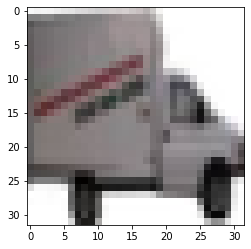

In [ ]:
i = 0
for train_images, _ in trainloader:  
    sample_train_image = train_images[0] 
    i += 1
    if i == 3:
      break  
plt.imshow(sample_train_image.reshape(3,32,32).permute(1,2,0))   

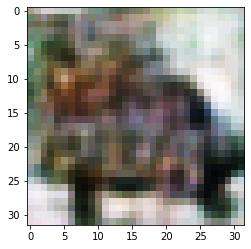

In [ ]:
with torch.no_grad(): 
  prediction = model(sample_train_image.unsqueeze(0).to(device))
  plt.imshow(prediction.cpu().reshape(3,32,32).permute(1,2,0))

In [ ]:
print(f"Pred: {prediction}, Sample: {sample_train_image}")

Pred: tensor([[[[-0.0304,  0.5053,  0.5022,  ...,  0.4445, -0.0041,  0.5285],
          [ 0.6265,  0.6073,  0.4726,  ..., -0.0562,  0.4721,  0.4507],
          [ 0.6039,  0.5291,  0.3885,  ...,  0.4588, -0.0157,  0.5798],
          ...,
          [ 0.1844,  0.1843, -0.0288,  ...,  0.2814,  0.2144,  0.2324],
          [ 0.2037,  0.1733,  0.2273,  ...,  0.2141,  0.1032,  0.2038],
          [ 0.3970,  0.2690,  0.2171,  ..., -0.1121,  0.3130,  0.3311]],

         [[ 0.6885,  0.7504,  0.8962,  ...,  0.5988,  0.6479,  0.7084],
          [-0.0025,  0.8644,  0.9975,  ...,  0.7763,  0.7665,  0.7744],
          [ 0.7807,  0.8433,  0.9086,  ...,  0.8546,  0.7004,  0.6793],
          ...,
          [ 0.3536,  0.3896,  0.3778,  ...,  0.3353,  0.2713,  0.3668],
          [ 0.4496,  0.3269,  0.3944,  ...,  0.3700, -0.0211, -0.0090],
          [-0.0442, -0.0017,  0.4832,  ..., -0.0548, -0.1353,  0.2882]],

         [[ 0.9462,  1.0128, -0.0169,  ...,  0.8885,  0.8781,  0.8226],
          [-0.0101,  1.0

In [ ]:
sample_train_image[:,1,0]

tensor([0.5882, 0.8471, 0.9961])

In [ ]:
prediction.cpu().reshape(3,32,32).permute(1,2,0)[1,0,:]

tensor([ 0.6265, -0.0025, -0.0101])

In [ ]:
test_img = torch.rand((1,3,32,32))

upsampled_test = nn.functional.interpolate(test_img,scale_factor = 2, mode = 'bicubic')
print(upsampled_test.shape)

torch.Size([1, 3, 64, 64])


tensor([[[-0.8000, -0.8000,  0.8000],
         [-0.8000, -0.8000,  0.8000],
         [-0.8000, -0.8000,  0.8000],
         [-0.8000, -0.8000,  0.8000]],

        [[-0.8000, -0.8000,  0.8000],
         [-0.8000, -0.8000,  0.8000],
         [-0.8000, -0.8000,  0.8000],
         [-0.8000, -0.8000,  0.8000]],

        [[-0.3000, -0.3000,  0.3000],
         [-0.3000, -0.3000,  0.3000],
         [-0.3000, -0.3000,  0.3000],
         [-0.3000, -0.3000,  0.3000]],

        [[-0.3000, -0.3000,  0.3000],
         [-0.3000, -0.3000,  0.3000],
         [-0.3000, -0.3000,  0.3000],
         [-0.3000, -0.3000,  0.3000]],

        [[-0.3000, -0.3000,  0.3000],
         [-0.3000, -0.3000,  0.3000],
         [-0.3000, -0.3000,  0.3000],
         [-0.3000, -0.3000,  0.3000]]])


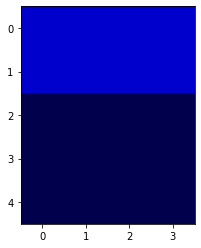

In [ ]:
test_img = torch.ones((5,4,3))*0.3
test_img[[0,1],:,:] += torch.ones(2,4,3)*0.5
test_img[:,:,[0 ,1]] *= -1
plt.imshow(test_img)
print(test_img)

Transpose Convolution Test

In [ ]:
test_img = torch.rand((1,3,4,4))
conv1 = nn.Conv2d(3,6,9,stride=2,padding = 4)
tconv1 = nn.ConvTranspose2d(6,3,9,stride=2, padding = 4, padding_mode = 'zeros', output_padding =1)

In [ ]:
out = conv1(test_img)
print(out.shape)

torch.Size([1, 6, 2, 2])


In [ ]:
inp = tconv1(out)
print(inp,test_img)

tensor([[[[-0.0086, -0.0083,  0.0496, -0.0033],
          [ 0.0780, -0.0133,  0.0247, -0.0376],
          [ 0.0161, -0.0291, -0.0205,  0.0035],
          [ 0.0167, -0.0012,  0.0644,  0.0330]],

         [[-0.0610, -0.0690, -0.1254, -0.0404],
          [-0.0793, -0.0464, -0.0442, -0.0613],
          [-0.0379, -0.0891, -0.0516, -0.0814],
          [-0.0920, -0.1054, -0.0521, -0.1036]],

         [[-0.0197, -0.0046, -0.0123, -0.0380],
          [-0.0099, -0.0208, -0.0200,  0.0110],
          [-0.0848, -0.0005, -0.0024, -0.0717],
          [ 0.0500, -0.0403,  0.0310,  0.0222]]]],
       grad_fn=<ConvolutionBackward0>) tensor([[[[0.6772, 0.3688, 0.6604, 0.7083],
          [0.1725, 0.2043, 0.4134, 0.3527],
          [0.9243, 0.7630, 0.9189, 0.0444],
          [0.1588, 0.3466, 0.1642, 0.8677]],

         [[0.7165, 0.6763, 0.6757, 0.2020],
          [0.5091, 0.8607, 0.7486, 0.7892],
          [0.2434, 0.6277, 0.0537, 0.3956],
          [0.0805, 0.4254, 0.3593, 0.8802]],

         [[0.6234, 0.9